# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [ ]:
# Requirements
!pip install yahoo_fin

In [ ]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import csv

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [ ]:
# File to write prediction result to CSV file
header = ['Date', 'Ticker', 'Next_Day01', 'Next_Day02', 'Next_Day03']

with open('predictions.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)


In [ ]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock tickers: - update with looping
    """
    TATAMOTORS.NS
    TATASTEEL.NS
    POWERGRID.NS
    NTPC.NS
    ITC.NS
    INFY.NS
    AXISBANK.NS
    GRASIM.NS
    SBIN.NS
    ONGC.NS
    IOC.NS
    BPCL.NS
    HINDALCO.NS
    HDFCBANK.NS
    HAL.NS
    """
STOCK = 'SBIN.NS'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [ ]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [ ]:
init_df.tail(12)

,open,high,low,close,adjclose,volume,ticker
2023-07-26,612.000000,616.349976,609.150024,615.150024,615.150024,9999125,SBIN.NS
2023-07-27,616.400024,621.250000,613.099976,616.549988,616.549988,17444742,SBIN.NS
2023-07-28,616.400024,619.900024,613.599976,616.049988,616.049988,11930586,SBIN.NS
2023-07-31,616.650024,621.000000,614.500000,620.200012,620.200012,8605483,SBIN.NS
2023-08-01,620.200012,620.849976,610.599976,611.849976,611.849976,13493453,SBIN.NS
2023-08-02,609.849976,610.500000,594.099976,598.450012,598.450012,14977497,SBIN.NS
2023-08-03,598.700012,600.849976,585.000000,590.500000,590.500000,27774877,SBIN.NS
2023-08-04,594.799988,598.700012,571.400024,573.299988,573.299988,52725616,SBIN.NS
2023-08-07,577.000000,577.000000,566.650024,567.900024,567.900024,32736325,SBIN.NS
2023-08-08,571.000000,574.250000,568.450012,573.099976,573.099976,25038671,SBIN.NS


In [ ]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [ ]:
init_df

,close,date
2020-08-03,192.250000,2020-08-03
2020-08-04,191.600006,2020-08-04
2020-08-05,191.449997,2020-08-05
2020-08-06,190.949997,2020-08-06
2020-08-07,190.649994,2020-08-07
...,...,...
2023-08-04,573.299988,2023-08-04
2023-08-07,567.900024,2023-08-07
2023-08-08,573.099976,2023-08-08
2023-08-09,573.750000,2023-08-09


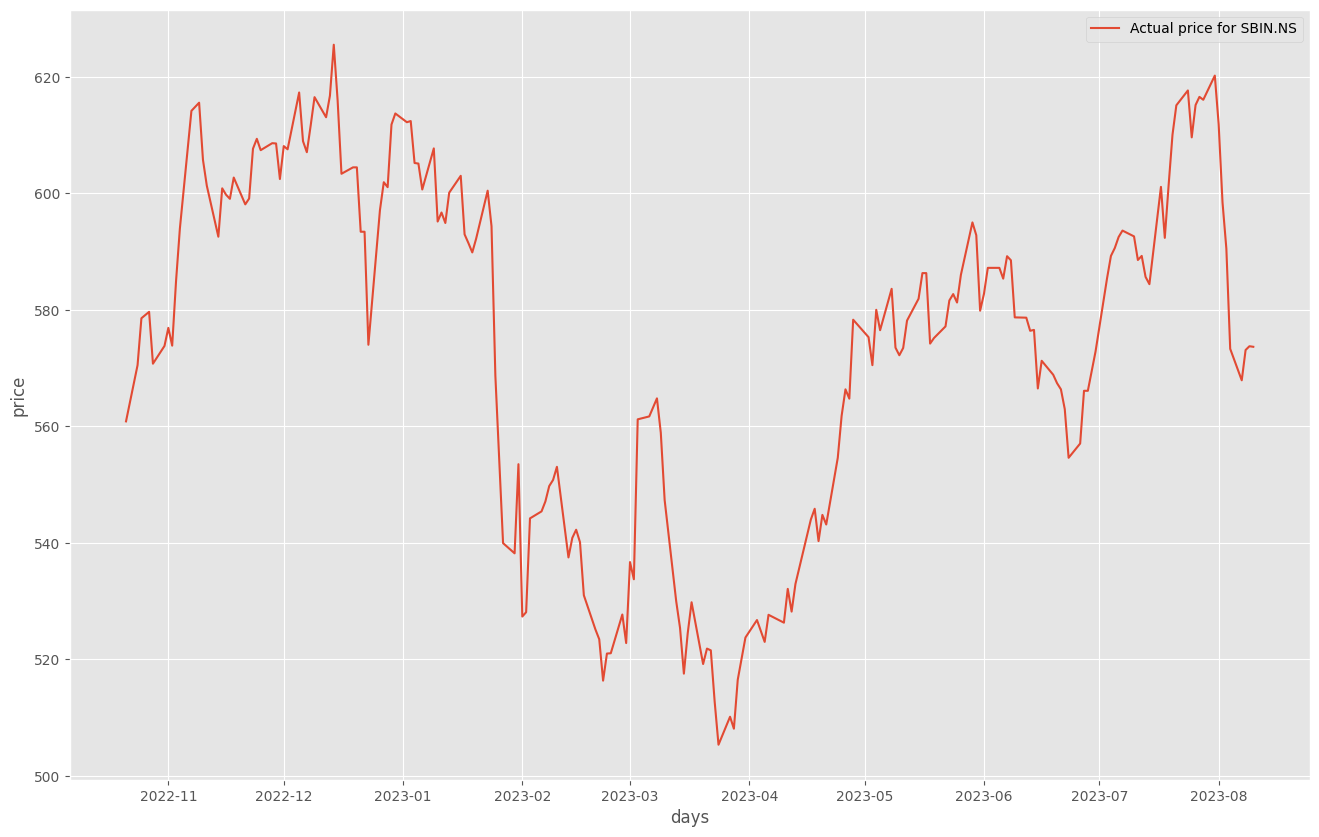

In [ ]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [ ]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [ ]:
init_df

,close,date,scaled_close
2020-08-03,192.250000,2020-08-03,0.035400
2020-08-04,191.600006,2020-08-04,0.033953
2020-08-05,191.449997,2020-08-05,0.033619
2020-08-06,190.949997,2020-08-06,0.032506
2020-08-07,190.649994,2020-08-07,0.031838
...,...,...,...
2023-08-04,573.299988,2023-08-04,0.883780
2023-08-07,567.900024,2023-08-07,0.871758
2023-08-08,573.099976,2023-08-08,0.883335
2023-08-09,573.750000,2023-08-09,0.884782


In [ ]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [ ]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2020-08-03  192.250000 2020-08-03      0.035400  0.032506
 2020-08-04  191.600006 2020-08-04      0.033953  0.031838
 2020-08-05  191.449997 2020-08-05      0.033619  0.038851
 2020-08-06  190.949997 2020-08-06      0.032506  0.041634
 2020-08-07  190.649994 2020-08-07      0.031838  0.060002
 ...                ...        ...           ...       ...
 2023-08-01  611.849976 2023-08-01      0.969609  0.883780
 2023-08-02  598.450012 2023-08-02      0.939775  0.871758
 2023-08-03  590.500000 2023-08-03      0.922075  0.883335
 2023-08-04  573.299988 2023-08-04      0.883780  0.884782
 2023-08-07  567.900024 2023-08-07      0.871758  0.884560
 
 [750 rows x 4 columns],
 array([[0.9789602 ],
        [0.98819995],
        [0.9696092 ],
        [0.93977517],
        [0.92207503],
        [0.8837804 ],
        [0.8717578 ],
        [0.8833351 ],
        [0.8847824 ],
        [0.88455975]], dtype=float32),
 array([[[0.0354001872705109

In [ ]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [ ]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
94/94 [==============================] - 9s 14ms/step - loss: 0.0240
Epoch 2/80
94/94 [==============================] - 2s 22ms/step - loss: 0.0054
Epoch 3/80
94/94 [==============================] - 3s 27ms/step - loss: 0.0041
Epoch 4/80
94/94 [==============================] - 2s 23ms/step - loss: 0.0038
Epoch 5/80
94/94 [==============================] - 3s 34ms/step - loss: 0.0045
Epoch 6/80
94/94 [==============================] - 2s 25ms/step - loss: 0.0035
Epoch 7/80
94/94 [==============================] - 2s 23ms/step - loss: 0.0034
Epoch 8/80
94/94 [==============================] - 2s 26ms/step - loss: 0.0029
Epoch 9/80
94/94 [==============================] - 3s 27ms/step - loss: 0.0027
Epoch 10/80
94/94 [==============================] - 4s 40ms/step - loss: 0.0024
Epoch 11/80
94/94 [==============================] - 3s 27ms/step - loss: 0.0025
Epoch 12/80
94/94 [==============================] - 3s 30ms/step - loss: 0.0021
Epoch 13/80
94/94 [==================

In [ ]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

SBIN.NS prediction for upcoming 3 days (579.52$, 570.61$, 568.91$)


In [ ]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 6ms/step


In [ ]:
# copy_df[1]

In [ ]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

<ipython-input-40-ca1349af6c77>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
<ipython-input-40-ca1349af6c77>:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]


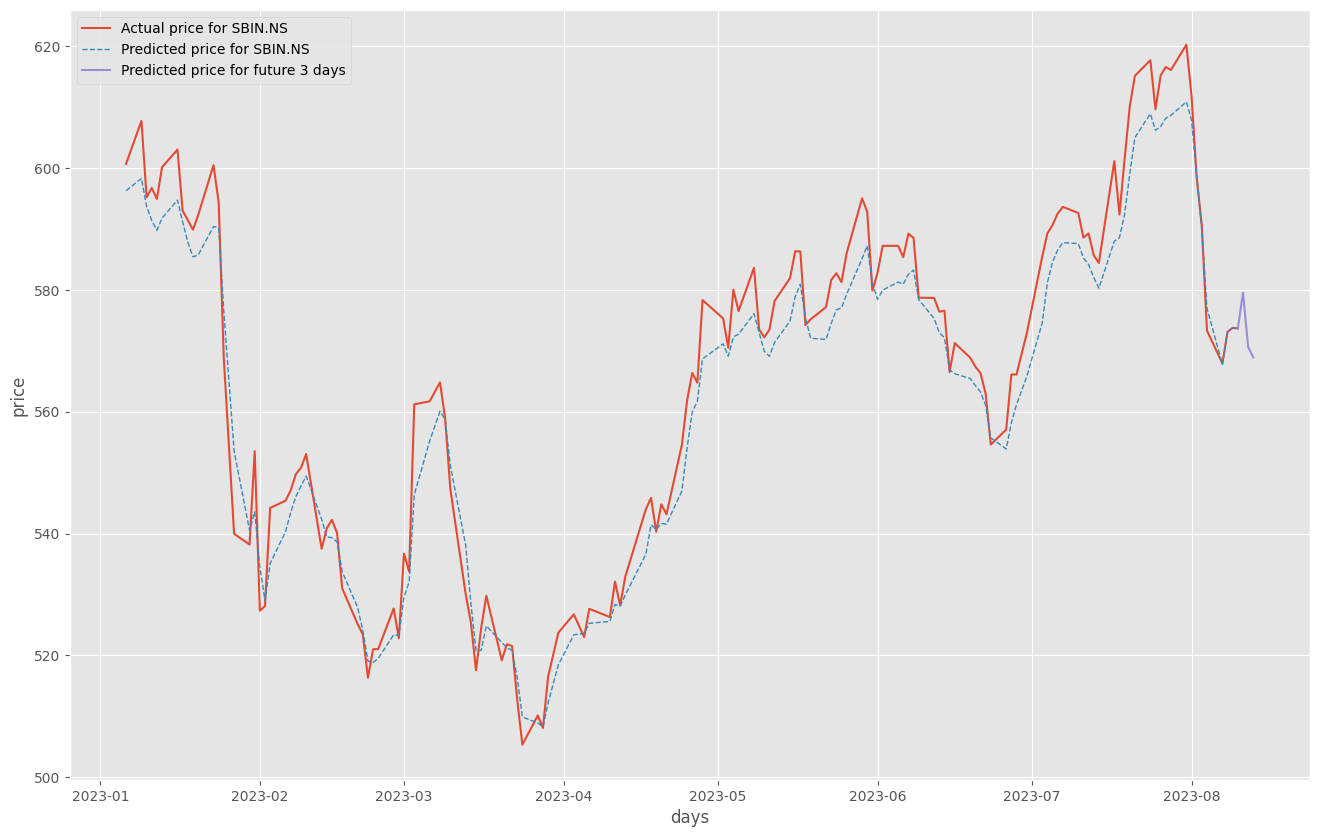

In [ ]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

In [ ]:
from datetime import datetime

today_date = datetime.today().strftime('%Y%m%d')
identifier = [today_date, STOCK]
# print(identifier)

predictions_list = ''
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'' for d in predictions]

# print(predictions_list)

predictions_next = identifier + predictions_list
# print(predictions_next)

with open('predictions.csv', 'a', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)

  # write the data
  writer.writerow(predictions_next)

print(predictions_next)


['20230811', 'SBIN.NS']
['579.52', '570.61', '568.91']
['20230811', 'SBIN.NS', '579.52', '570.61', '568.91']
['20230811', 'SBIN.NS', '579.52', '570.61', '568.91']
